In [1]:
# Description: Plot spectral properties of upstates and downstates in ECoG data and save figures. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import logging
from pathlib import Path
import matplotlib.patches as mpatches
from fooof.sim import gen_freqs
from scipy.stats import mannwhitneyu

# Set up file paths
file_path = str(Path().absolute())
project_path = str(Path().absolute().parent.parent)
exp_name = file_path.split('/')[-1]

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Current file directory: {file_path}")
logging.info(f"Current project directory: {project_path}")

os.chdir(project_path)
sys.path.append(project_path)

# Import custom modules
from src.utils import parse_spectrum

2023-07-25 15:22:36,378 - INFO - Current file directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves/exp/upstates-intervals
2023-07-25 15:22:36,379 - INFO - Current project directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves


In [2]:
exps = ['w12_18.spont','w12_07.spont']
probes = ['ECoG', 'Probe_1', 'Probe_2']
intervals = ['upstate', 'downstate']

In [3]:
from collections import defaultdict
beta_band_graph = defaultdict(list)

# For each experiment
for exp in exps:
    # For each probe
    for probe in probes:
        # Skip ECoG
        if probe == 'ECoG':
            continue
        # Load the data

        df = pd.read_csv(f'res/upstates-intervals/spectral_properties_{exp}_{probe}.csv')
        # Drop nans 
        df = df.dropna()
        # Get channels list
        channels = df['Channel'].unique()

        # For each channel
        for channel in channels:
            # Get the data for the channel
            df_channel = df[df['Channel'] == channel]

            freqs_list_intervals, powers_list_intervals = [], []
            # For each interval
            for interval in intervals:
                # Get power spectrum
                data = df_channel[df_channel['State'] == interval]

                # Get power spectrum for upstates
                freqs_data = data['Power spectrum (freqs)'].values
                freqs, powers = parse_spectrum(freqs_data, data['Power spectrum (powers)'].values)

                freqs_list_intervals.append(freqs)
                powers_list_intervals.append(powers)

                # Get beta band power for upstates and downstates
                beta_band = np.where((np.array(freqs) >= 12) & (np.array(freqs) <= 30))
                beta_power = np.mean(np.array(powers)[beta_band])

                # Get gamma band power for upstates and downstates
                gamma_band = np.where((np.array(freqs) >= 30) & (np.array(freqs) <= 50))
                gamma_power = np.mean(np.array(powers)[gamma_band])

                # Get alpha band power for upstates and downstates
                alpha_band = np.where((np.array(freqs) >= 8) & (np.array(freqs) <= 12))
                alpha_power = np.mean(np.array(powers)[alpha_band])
    

                # Append to list in beta_band_graph dict
                beta_band_graph['Depth'].append(channel * 100)
                beta_band_graph['Interval'].append(interval)
                beta_band_graph['Beta power'].append(beta_power)
                beta_band_graph['Gamma power'].append(gamma_power)
                beta_band_graph['Alpha power'].append(alpha_power)
                beta_band_graph['Probe'].append(probe)
                beta_band_graph['Experiment'].append(exp)

      
bands_graph = pd.DataFrame(beta_band_graph) 
bands_graph

FileNotFoundError: [Errno 2] No such file or directory: 'res/upstates-intervals/spectral_properties_w12_18.spont_Probe_1.csv'

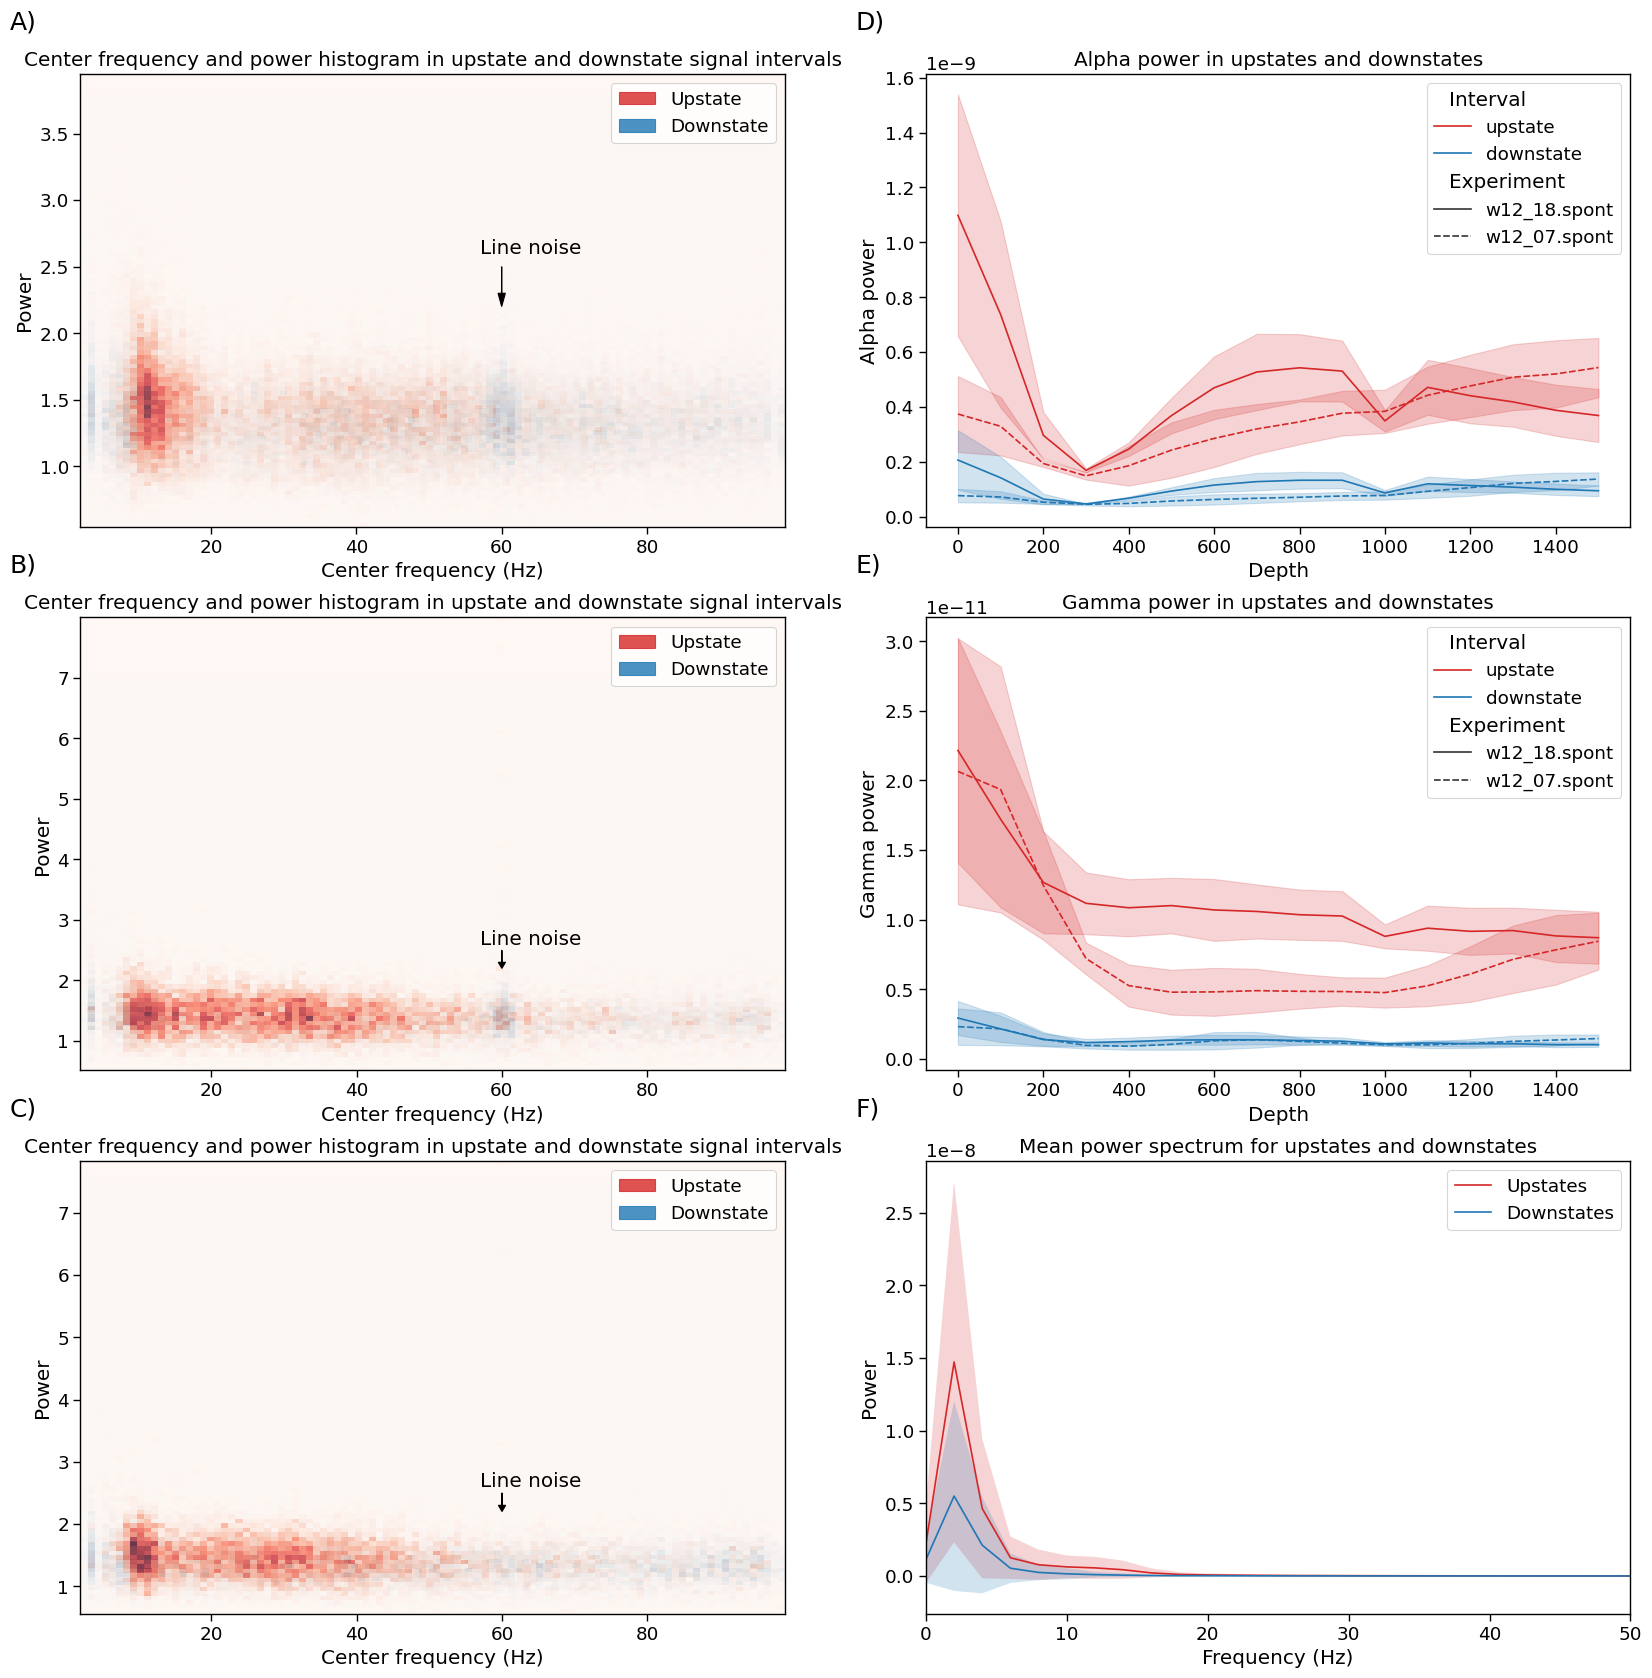

In [7]:
from matplotlib.gridspec import GridSpec
from neurodsp.filt import filter_signal

# Set global style seaborn-v0_8-paper
sns.set_context('paper', font_scale=1.5)

# Set color palette and style
color_palette = ['tab:red', 'tab:blue', 'green']
sns.set_palette(color_palette)


# Set GridSpec for the figure
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])  # Axis for 2D histogram with power versus center frequency for ECoG data experiment 18
ax2 = fig.add_subplot(gs[1, 0])  # Axis for 2D histogram with power versus center frequency for Probe 1 data experiment 18
ax3 = fig.add_subplot(gs[2, 0])  # Axis for 2D histogram with power versus center frequency for Probe 2 data experiment 18
ax5 = fig.add_subplot(gs[0, 1])  # Axis for graph with power in beta band on y-axis and depth on x-axis for all probes and all experiments!
ax6 = fig.add_subplot(gs[1, 1])  # Axis for graph with power in gamma band on y-axis and depth on x-axis for all probes and all experiments!
ax7 = fig.add_subplot(gs[2, 1])  # Extra axis

# Load data
ecog_18_data = pd.read_csv('res/upstates-intervals/spectral_properties_w12_18.spont_ECoG.csv')
probe1_18_data = pd.read_csv('res/upstates-intervals/spectral_properties_w12_18.spont_Probe_1.csv')
probe2_18_data = pd.read_csv('res/upstates-intervals/spectral_properties_w12_18.spont_Probe_2.csv')
ecog_raw = np.load('data/processed/w12_18.spont/1kHz/ts_filtered_ecog.npy')[0]
times = np.load('data/processed/w12_18.spont/1kHz/times.npy')
event_times = np.load('data/processed/w12_18.spont/1kHz/event_times.npy')

# Remove nans from data
ecog_18_data = ecog_18_data.dropna()
probe1_18_data = probe1_18_data.dropna()
probe2_18_data = probe2_18_data.dropna()

# Get upstate and downstate data for ECoG
ecog_18_data_upstate_data = ecog_18_data[ecog_18_data['State'] == 'upstate']
ecog_18_data_downstate_data = ecog_18_data[ecog_18_data['State'] == 'downstate']

# Get upstate and downstate data for Probe 1
probe1_18_data_upstate_data = probe1_18_data[probe1_18_data['State'] == 'upstate']
probe1_18_data_downstate_data = probe1_18_data[probe1_18_data['State'] == 'downstate']

# Get upstate and downstate data for Probe 2
probe2_18_data_upstate_data = probe2_18_data[probe2_18_data['State'] == 'upstate']
probe2_18_data_downstate_data = probe2_18_data[probe2_18_data['State'] == 'downstate']

# Plot 2D histograms for ECoG data
h2 = ax1.hist2d(ecog_18_data_downstate_data['Central frequencies'], ecog_18_data_downstate_data['Peak powers'],
                bins=100, cmap='Blues', alpha=0.7, label='Downstate')
h1 = ax1.hist2d(ecog_18_data_upstate_data['Central frequencies'], ecog_18_data_upstate_data['Peak powers'],
                bins=100, cmap='Reds', alpha=0.7, label='Upstate')
ax1.legend(handles=[mpatches.Patch(color=color_palette[0], label='Upstate', alpha=0.8),
                    mpatches.Patch(color=color_palette[1], label='Downstate', alpha=0.8)])
ax1.arrow(60, 2.5, 0, -0.2, head_width=1, head_length=0.1, fc='k', ec='k')
ax1.text(57, 2.6, 'Line noise', color='k')
ax1.set_xlabel('Center frequency (Hz)')
ax1.set_ylabel('Power')
ax1.set_title('Center frequency and power histogram in upstate and downstate signal intervals')



# Plot 2D histograms for Probe 1 data
h2 = ax2.hist2d(probe1_18_data_downstate_data['Central frequencies'], probe1_18_data_downstate_data['Peak powers'],
                bins=100, cmap='Blues', alpha=0.7, label='Downstate')
h1 = ax2.hist2d(probe1_18_data_upstate_data['Central frequencies'], probe1_18_data_upstate_data['Peak powers'],
                bins=100, cmap='Reds', alpha=0.7, label='Upstate')
ax2.legend(handles=[mpatches.Patch(color=color_palette[0], label='Upstate', alpha=0.8),
                    mpatches.Patch(color=color_palette[1], label='Downstate', alpha=0.8)])
ax2.arrow(60, 2.5, 0, -0.2, head_width=1, head_length=0.1, fc='k', ec='k')
ax2.text(57, 2.6, 'Line noise', color='k')
ax2.set_xlabel('Center frequency (Hz)')
ax2.set_ylabel('Power')
ax2.set_title('Center frequency and power histogram in upstate and downstate signal intervals')



# Plot 2D histograms for Probe 2 data
h2 = ax3.hist2d(probe2_18_data_downstate_data['Central frequencies'], probe2_18_data_downstate_data['Peak powers'],
                bins=100, cmap='Blues', alpha=0.7, label='Downstate')
h1 = ax3.hist2d(probe2_18_data_upstate_data['Central frequencies'], probe2_18_data_upstate_data['Peak powers'],
                bins=100, cmap='Reds', alpha=0.7, label='Upstate')
ax3.legend(handles=[mpatches.Patch(color=color_palette[0], label='Upstate', alpha=0.8),
                    mpatches.Patch(color=color_palette[1], label='Downstate', alpha=0.8)])
ax3.arrow(60, 2.5, 0, -0.2, head_width=1, head_length=0.1, fc='k', ec='k')
ax3.text(57, 2.6, 'Line noise', color='k')
ax3.set_xlabel('Center frequency (Hz)')
ax3.set_ylabel('Power')
ax3.set_title('Center frequency and power histogram in upstate and downstate signal intervals')


for band, ax in zip(['Alpha', 'Gamma'], [ax5, ax6]):
    # plot graph channels on x axis, beta power on y axis, hue = interval, style = experiment
    sns.lineplot(data=beta_band_graph, x='Depth', y=f'{band} power', hue='Interval', style='Experiment', ax=ax)

    ax.set_xlabel('Depth')
    ax.set_ylabel(f'{band} power')
    ax.set_title(f'{band} power in upstates and downstates')

freqs_list_intervals = np.array(freqs_list_intervals)
powers_list_intervals = np.array(powers_list_intervals)

freqs_list_upstates = freqs_list_intervals[0]
freqs_list_downstates = freqs_list_intervals[1]

powers_list_upstates = powers_list_intervals[0]
powers_list_downstates = powers_list_intervals[1]


# plot mean through all intervals 
ax7.plot(freqs_list_upstates[0], np.mean(powers_list_upstates, axis=0), label='Upstates')
ax7.plot(freqs_list_downstates[0], np.mean(powers_list_downstates, axis=0), label='Downstates')
# Add standard deviation
ax7.fill_between(freqs_list_upstates[0], np.mean(powers_list_upstates, axis=0) - np.std(powers_list_upstates, axis=0), np.mean(powers_list_upstates, axis=0) + np.std(powers_list_upstates, axis=0), alpha=0.2)
ax7.fill_between(freqs_list_downstates[0], np.mean(powers_list_downstates, axis=0) - np.std(powers_list_downstates, axis=0), np.mean(powers_list_downstates, axis=0) + np.std(powers_list_downstates, axis=0), alpha=0.2)

ax7.set_xlabel('Frequency (Hz)')
ax7.set_ylabel('Power')
# Set x axis limits
ax7.set_xlim(0, 50)
ax7.legend()
ax7.set_title('Mean power spectrum for upstates and downstates')


# # Filter out only beta band
# ecog_raw_beta = filter_signal(ecog_raw, 1000, 'bandpass', [12, 30], n_seconds=1, remove_edges=False)
# # Plot upstates
# ax4.plot(times, ecog_raw_beta, label='Beta band signal', color='gray', lw=0.5)
# for upstate in event_times:
#     ax4.axvspan(upstate[0], upstate[1], alpha=0.1, color='green', label='Upstates')
# # set x axis limits
# ax4.set_xlim(100, 120)
# ax4.set_title('Raw signal overlaid with upstates and downstates (ECoG, beta band)')
# ax4.set_xlabel('Time (s)')
# ax4.set_ylabel('Voltage')

# Also add letters to the subplots 
ax1.text(-0.1, 1.1, 'A)', transform=ax1.transAxes, size=18)
ax2.text(-0.1, 1.1, 'B)', transform=ax2.transAxes, size=18)
ax3.text(-0.1, 1.1, 'C)', transform=ax3.transAxes, size=18)
# ax4.text(-0.1, 1.1, 'D)', transform=ax4.transAxes, size=18)
ax5.text(-0.1, 1.1, 'D)', transform=ax5.transAxes, size=18)
ax6.text(-0.1, 1.1, 'E)', transform=ax6.transAxes, size=18)
ax7.text(-0.1, 1.1, 'F)', transform=ax7.transAxes, size=18)

# Save figure
fig.savefig(f'exp/{exp_name}/figure_spectra.png', dpi=300, bbox_inches='tight')